### AE4465 (MM&A) - Lecture5 (C-MAPSS Case Study)

In prognostics and health management (PHM), we can study different cases of degradation. A popular one is to uncover the patterns of degradation of aircraft engines. In particular, NASA Research Ames provided data of turbofan degradation based on a simulator (C-MAPSS) developed at Glenn Research Center. We use here that data to show different operational conditions.

In this tutorial we will explore the C-MAPSS case study. Below we summarize each dataset.

| Data Set | Train trajectories | Test trajectories | Conditions     | Fault modes                           |
| -------- | ------------------ | ----------------- | -------------- | ------------------------------------- |
| FD001    | 100                | 100               | One(sea level) | One(HPD Degradation)                  |
| FD002    | 260                | 259               | Six            | One(HPC degradation)                  |
| FD003    | 100                | 100               | One            | Two(HPC degradation, fan degradation) |
| FD004    | 249                | 248               | Six            | Two(HPC degradation, fan degradation) |

| Train Data Set | Number of row | Test Data Set | Number of row | RUL Data Set | Number of row |
| -------------- | ------------- | ------------- | ------------- | ------------ | ------------- |
| FD001          | 20631         | FD001         | 13096         | FD001        | 100           |
| FD002          | 53759         | FD002         | 33991         | FD002        | 259           |
| FD003          | 24720         | FD003         | 16596         | FD003        | 100           |
| FD004          | 61249         | FD004         | 41214         | FD004        | 248           |

Each dataset has 26 columns.
The columns correspond to:

1)	unit number
2)	time, in cycles
3)	operational setting 1
4)	operational setting 2
5)	operational setting 3
6)	sensor measurement  1
7)	sensor measurement  2
...
26)	sensor measurement  26


In [32]:
#import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy.stats
# Though the following import is not directly being used, it is required
# for 3D projection to work with matplotlib < 3.2
import mpl_toolkits.mplot3d  # noqa: F401

from sklearn.cluster import KMeans

In [77]:
# Import the data in csv file
df1 = pd.read_csv('data/les05_CMAPSStrain001.txt', sep=' ')
df2 = pd.read_csv('data/les05_CMAPSStrain002.txt', sep=' ')
df3 = pd.read_csv('data/les05_CMAPSStrain003.txt', sep=' ')
df4 = pd.read_csv('data/les05_CMAPSStrain004.txt', sep=' ')
df1.head()

,Equipment,Cycle,Op1,Op2,Op3,1,2,3,4,5,...,12,13,14,15,16,17,18,19,20,21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


### Analysis of all sensors of one engine [Engine 1 - TrainFD001]

It is possible to analyze all the sensor trajectories of one engine in FD001 (first dataset).
We can see that some sensors bring no information as they are flat while others have a clearly more indicative trajectory of degradation.

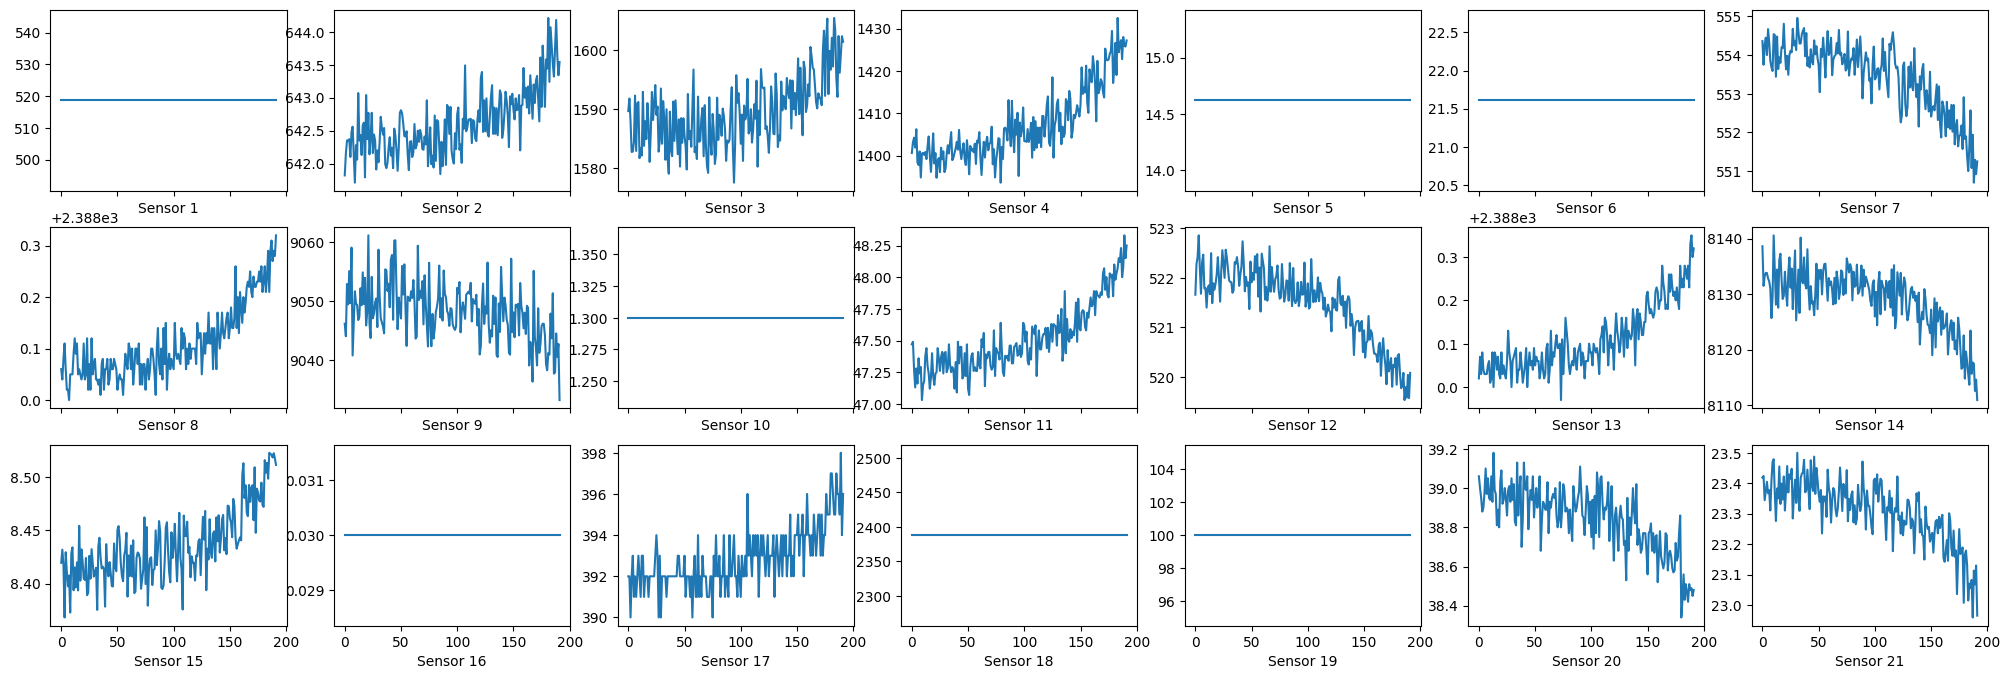

In [75]:
fig, axes = plt.subplots(nrows=3, ncols=7, sharex=True,
                                    figsize=(25, 8))
id_equipment = 1
mask_equip1 = df1['Equipment'] == id_equipment# Select column Equipment with value x

m = 1
for i in range(3):
    for j in range(7):
        signal = df1.loc[mask_equip1,str(m)]
        axes[i,j].plot(range(len(signal)), signal)
        axes[i,j].set_xlabel('Sensor ' + str(m))
        m += 1

plt.show()

### Analysis of several engines of one sensor

It is also possible to analyze the trajectories of the same sensor to check visually for monotonicity and other interesting patterns.


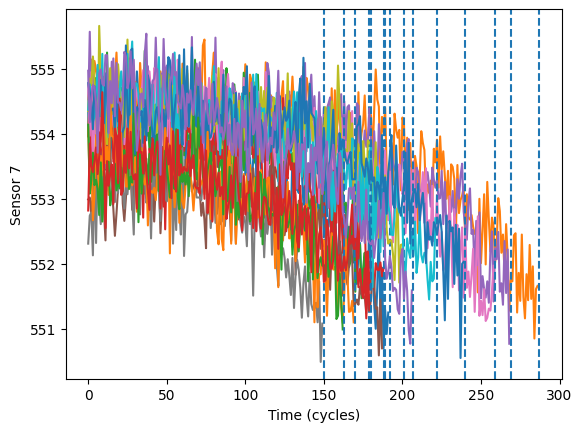

In [29]:
# print sensor 1 for 15 engines

for i in range(15):
    id_equipment = i + 1
    mask_equip1 = df1['Equipment'] == id_equipment # Select column Equipment with value x
    signal = df1.loc[mask_equip1, '7']
    plt.plot(range(len(signal)), signal)
    plt.xlabel('Time (cycles)')
    plt.axvline(len(signal), linestyle='--')
    plt.ylabel('Sensor 7')

plt.show()

### Operational Conditions

In df2 we can see different operational conditions

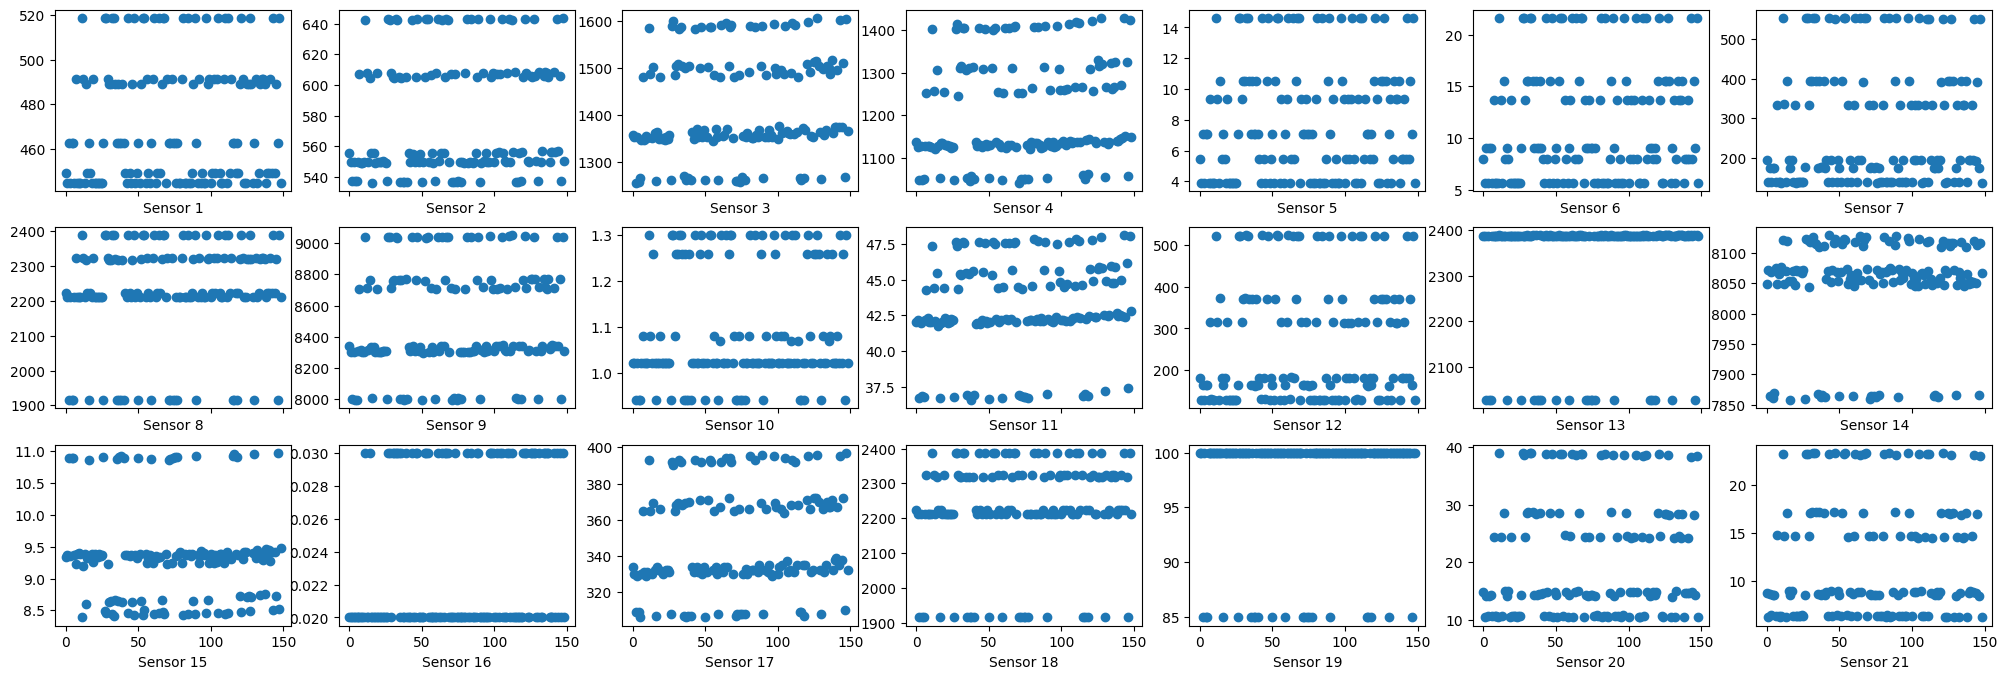

In [89]:
fig, axes = plt.subplots(nrows=3, ncols=7, sharex=True,
                                    figsize=(25, 8))
df2 = pd.read_csv('data/les05_CMAPSStrain002.txt', sep=' ')
id_equipment = 1
mask_equip1 = df2['Equipment'] == id_equipment# Select column Equipment with value x
nrow = 0
ncol = 0

m=1
for ax in axes.ravel():
    signal = df2.loc[mask_equip1,str(m)]
    ax.scatter(range(len(signal)), signal)
    ax.set_xlabel('Sensor ' + str(m))
    m += 1

plt.show()

### Data normalization

To place all trajectories under the same conditions, we need first to identify the conditions through clustering and then normalize within each condition.

In [92]:
kmeans_model = KMeans(n_clusters=6)
df2 = pd.read_csv('data/les05_CMAPSStrain002.txt', sep=' ')
est = kmeans_model.fit(df2[['Op1', 'Op2', 'Op3']])
clusters = est.labels_
for feature in range(21):
    for cluster in np.unique(clusters):
        data_cluster = df2[clusters == cluster][str(feature + 1)]
        stdev = np.std(data_cluster)
        mean = np.mean(data_cluster)
        data_cluster = ( data_cluster - mean ) / stdev
        df2.loc[clusters == cluster, str(feature + 1)] = data_cluster.values


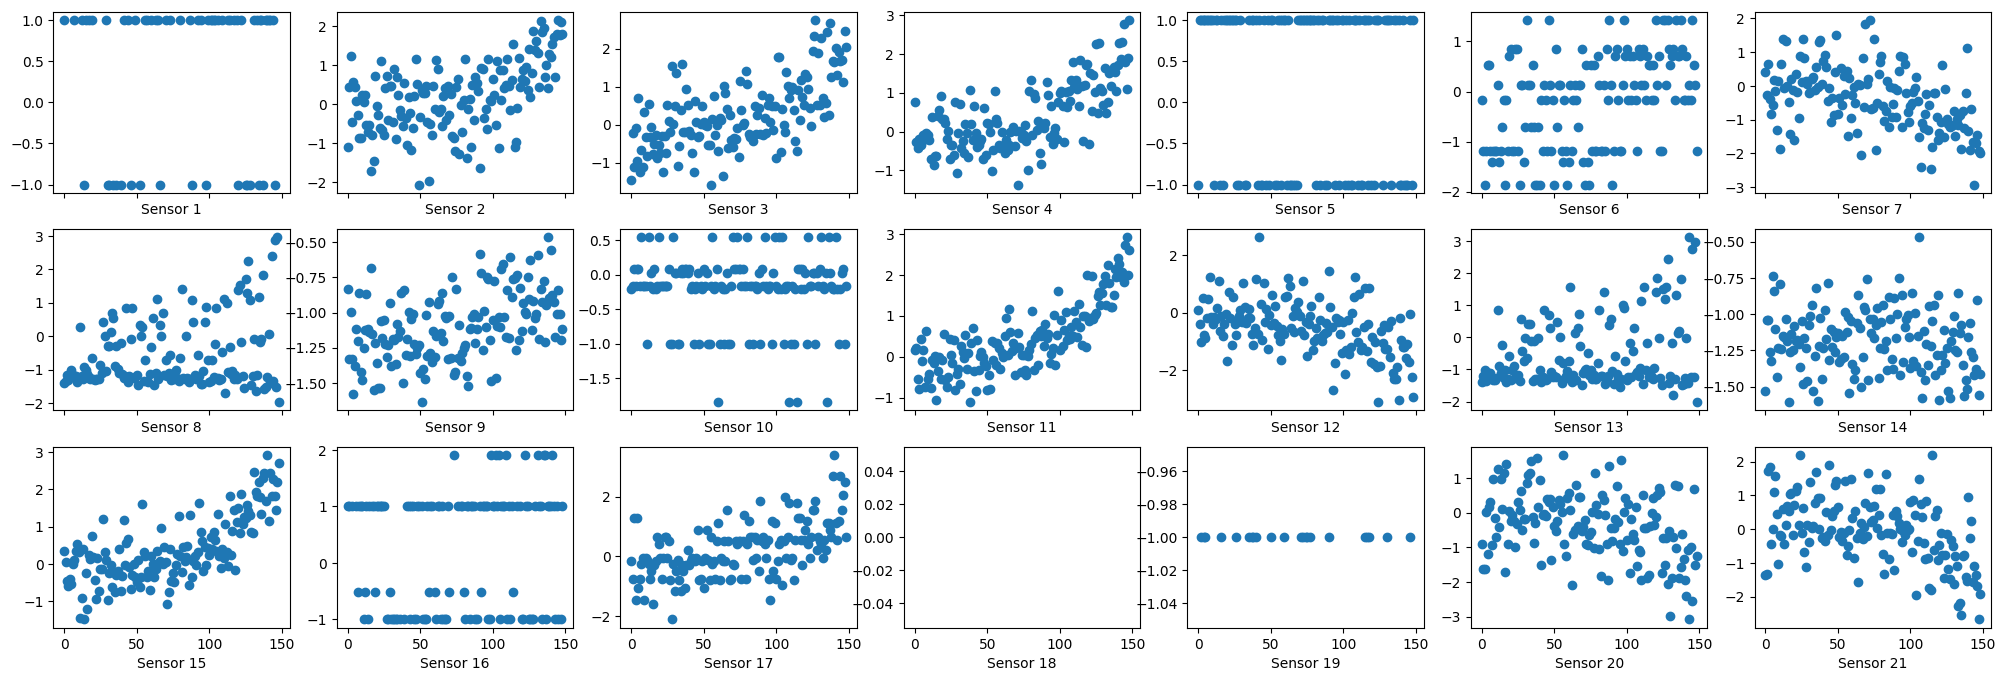

In [93]:
fig, axes = plt.subplots(nrows=3, ncols=7, sharex=True,
                                    figsize=(25, 8))
id_equipment = 1
mask_equip1 = df2['Equipment'] == id_equipment# Select column Equipment with value x
nrow = 0
ncol = 0

m=1
for ax in axes.ravel():
    signal = df2.loc[mask_equip1,str(m)]
    ax.scatter(range(len(signal)), signal)
    ax.set_xlabel('Sensor ' + str(m))
    m += 1

plt.show()